In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [3]:
# Check if GPU is available and set memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Memory growth set')

Memory growth set


In [4]:
# Load birds.csv
birds_df = pd.read_csv('birds.csv')

In [5]:
# Check class distribution
train_counts = birds_df[birds_df['dataset'] == 'train']['labels'].value_counts()
test_counts = birds_df[birds_df['dataset'] == 'test']['labels'].value_counts()
valid_counts = birds_df[birds_df['dataset'] == 'valid']['labels'].value_counts()

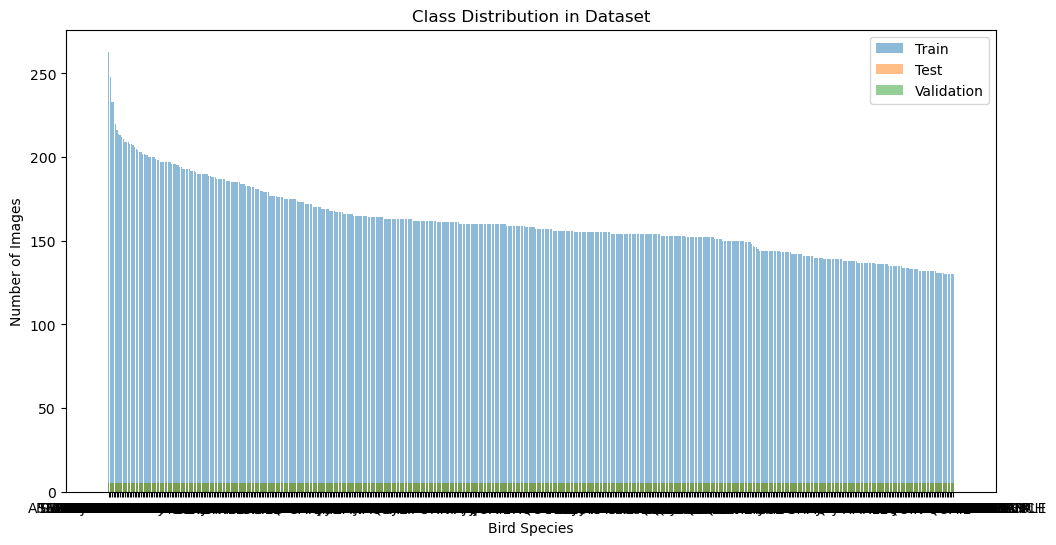

In [6]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(train_counts.index, train_counts.values, alpha=0.5, label='Train')
plt.bar(test_counts.index, test_counts.values, alpha=0.5, label='Test')
plt.bar(valid_counts.index, valid_counts.values, alpha=0.5, label='Validation')
plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.legend()
plt.show()

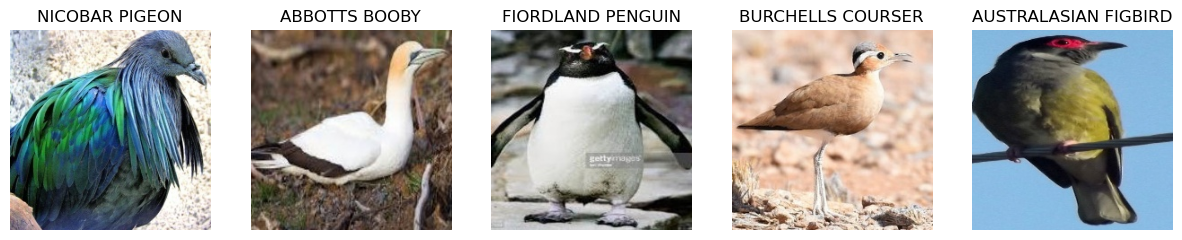

In [7]:
# Display sample images
sample_images = birds_df[birds_df['dataset'] == 'train'].sample(n=5)

plt.figure(figsize=(15, 6))
for i, (index, bird) in enumerate(sample_images.iterrows()):
    plt.subplot(1, 5, i + 1)
    img = Image.open(bird['filepaths'])
    plt.imshow(img)
    plt.title(bird['labels'])
    plt.axis('off')
plt.show()

In [8]:
# Define paths
train_dir = 'train'
test_dir = 'test'
val_dir = 'valid'

In [9]:
# Data augmentation and normalization
img_height = 150
img_width = 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalization

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Ensure categorical labels
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Ensure categorical labels
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [10]:
# Define model builder function for hyperparameter tuning
def build_model(filters, units, dropout_rate, learning_rate):
    model = Sequential([
        Conv2D(filters, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(filters, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(filters, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(units, activation='relu'),
        Dropout(dropout_rate),
        Dense(525, activation='softmax')  # Assuming 525 classes
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
# Grid search for hyperparameter tuning
def grid_search(train_generator, val_generator):
    filters = [64, 128]
    units = [512, 1024]
    dropout_rates = [0, 0.3]
    learning_rates = [1e-3, 1e-4]
    
    best_val_accuracy = 0
    best_params = {}
    
    for filter_val in filters:
        for unit in units:
            for dropout_rate in dropout_rates:
                for learning_rate in learning_rates:
                    print(f"Testing model with filters={filter_val}, units={unit}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
                    model = build_model(filter_val, unit, dropout_rate, learning_rate)
                    
                    history = model.fit(
                        train_generator,
                        steps_per_epoch=train_generator.samples // batch_size,
                        epochs=5,  # Use fewer epochs for faster tuning
                        validation_data=val_generator,
                        validation_steps=val_generator.samples // batch_size
                    )
                    
                    val_accuracy = history.history['val_accuracy'][-1]
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {
                            'filters': filter_val,
                            'units': unit,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate
                        }
    
    print(f"Best validation accuracy: {best_val_accuracy}")
    print(f"Best parameters: {best_params}")
    return best_params

In [12]:
# Run grid search to find best hyperparameters
best_params = grid_search(train_generator, val_generator)

Testing model with filters=64, units=512, dropout_rate=0, learning_rate=0.001
Epoch 1/5
2644/2644 [==============================] - 269s 100ms/step - loss: 5.4326 - accuracy: 0.0373 - val_loss: 4.2889 - val_accuracy: 0.1345
Epoch 2/5
2644/2644 [==============================] - 255s 96ms/step - loss: 4.2988 - accuracy: 0.1447 - val_loss: 3.3107 - val_accuracy: 0.2980
Epoch 3/5
2644/2644 [==============================] - 243s 92ms/step - loss: 3.6732 - accuracy: 0.2354 - val_loss: 2.7413 - val_accuracy: 0.3960
Epoch 4/5
2644/2644 [==============================] - 255s 96ms/step - loss: 3.3149 - accuracy: 0.2922 - val_loss: 2.4484 - val_accuracy: 0.4531
Epoch 5/5
2644/2644 [==============================] - 238s 90ms/step - loss: 3.0714 - accuracy: 0.3335 - val_loss: 2.2652 - val_accuracy: 0.4867
Testing model with filters=64, units=512, dropout_rate=0, learning_rate=0.0001
Epoch 1/5
2644/2644 [==============================] - 245s 93ms/step - loss: 5.4267 - accuracy: 0.0426 - val_lo

In [13]:
# Build and train the final model with the best hyperparameters
best_model = build_model(best_params['filters'], best_params['units'], best_params['dropout_rate'], best_params['learning_rate'])

In [14]:
best_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 74, 74, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 17, 17, 128)    

In [15]:
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/20
2644/2644 [==============================] - 259s 98ms/step - loss: 5.1820 - accuracy: 0.0643 - val_loss: 3.9302 - val_accuracy: 0.2016
Epoch 2/20
2644/2644 [==============================] - 259s 98ms/step - loss: 4.0092 - accuracy: 0.1864 - val_loss: 3.2339 - val_accuracy: 0.3220
Epoch 3/20
2644/2644 [==============================] - 259s 98ms/step - loss: 3.4694 - accuracy: 0.2704 - val_loss: 2.7090 - val_accuracy: 0.4135
Epoch 4/20
2644/2644 [==============================] - 260s 98ms/step - loss: 3.0957 - accuracy: 0.3332 - val_loss: 2.5121 - val_accuracy: 0.4604
Epoch 5/20
2644/2644 [==============================] - 260s 98ms/step - loss: 2.8210 - accuracy: 0.3804 - val_loss: 2.2418 - val_accuracy: 0.5111
Epoch 6/20
2644/2644 [==============================] - 259s 98ms/step - loss: 2.6012 - accuracy: 0.4204 - val_loss: 2.1055 - val_accuracy: 0.5274
Epoch 7/20
2644/2644 [==============================] - 260s 98ms/step - loss: 2.4272 - accuracy: 0.4531 - val_loss: 1

In [16]:
# Evaluate the model on the test set
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Ensure categorical labels
)

test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

Found 2625 images belonging to 525 classes.
83/83 [==============================] - 2s 25ms/step - loss: 1.3075 - accuracy: 0.7063
Test accuracy: 0.7062857151031494


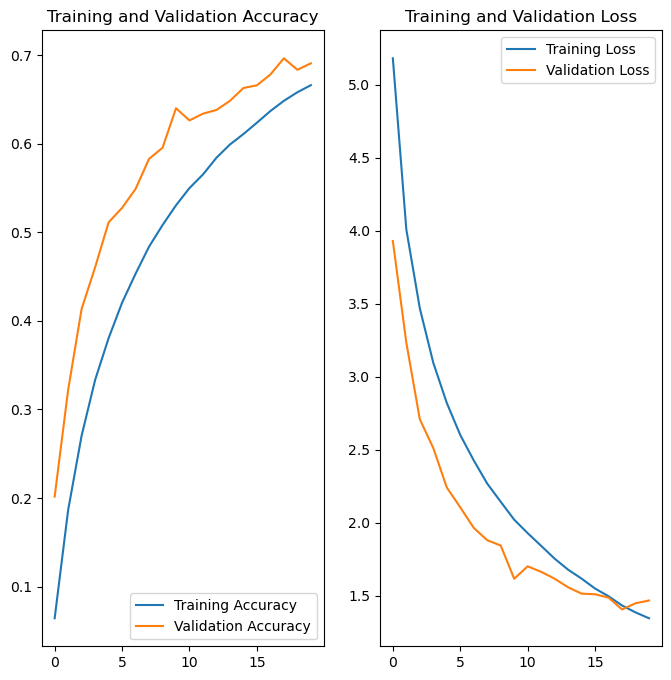

In [17]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()